In [1]:
import polars as pl
import networkx as nx

# don't want it to truncate dataframes so aggressively
pl.Config.set_tbl_rows(100)

data = 'data/wiki_network_science_artificial_life.csv'

# Load Data and Diagnostic Checks

I used the Day 5 Wikipedia Dataset Generator to create an edgelist relating to Network Science and Artificial Life. I want to see what the two topics have in common according to Wikipedia data. The first step is to load the dataset, create a graph with it, and do some quick diagnostic checks.

In [2]:
df = pl.read_csv(data)
df.head()

source,target
str,str
"""network science""","""Network science"""
"""network science""","""Hub (network science)"""
"""network science""","""National Science Foundation Ne…"
"""network science""","""Network theory"""
"""network science""","""Social network"""


In [3]:
df.shape

(10632, 2)

In [4]:
G = nx.from_pandas_edgelist(df)

drop_nodes = ['network science', 'artificial life'] # drop the seeds, keep the found pages
G.remove_nodes_from(drop_nodes)

print(G)

Graph with 6999 nodes and 10042 edges


# Node Distance

In networks, like attracts like. Things that are similar to each other are often linked together, but not always. Closeness will have to do with some relevancy, but distance is not an indicator of irrelevancy. It takes time for nodes to discover one another, and there may simply not be a connection yet. However, every graph is a snapshot of a network, and we can investigate the current reality, not the future reality. We can predict the future, but not explore it right now.

Distant nodes that are actually related may be discovered by using other techniques, such as Natural Language Processing techniques. Node similarity will be tied to the behavior of nodes in that way, and not based on network positioning. NLP and Network Science are very useful together in this way.

But for today's experiment, we will use network positioning only. An NLP approach can be on another day.

In [5]:
distance_network_science = nx.shortest_path_length(G, 'Network science') # distance from each node to network science
distance_artificial_life = nx.shortest_path_length(G, 'Artificial life') # same, for artificial life

In [6]:
df_ns = pl.DataFrame(distance_network_science).transpose(include_header=True).rename({'column_0':'distance_ns'})
df_al = pl.DataFrame(distance_artificial_life).transpose(include_header=True).rename({'column_0':'distance_al'})

In [7]:
df_ns.head() # 0 = no steps away from node of interest, 1 = one step away, etc

column,distance_ns
str,i64
"""Network science""",0
"""Efficiency (network science)""",1
"""Hub (network science)""",1
"""National Science Foundation Ne…",1
"""Network theory""",1


In [8]:
df_al.head()

column,distance_al
str,i64
"""Artificial life""",0
"""Artificial chemistry""",1
"""Artificial life (disambiguatio…",1
"""Synthetic biology""",1
"""Life support""",1


In [9]:
df_al.sort('distance_al', descending=False).head()

column,distance_al
str,i64
"""Artificial life""",0
"""Artificial chemistry""",1
"""Artificial life (disambiguatio…",1
"""Synthetic biology""",1
"""Life support""",1


In [10]:
df_al.sort('distance_al', descending=True).head()

column,distance_al
str,i64
"""Open network architecture""",9
"""Open Network for Digital Comme…",9
"""JAMA Network Open""",9
"""Open Architecture Network""",9
"""Open-access network""",9


# Combine the Dataframes

Next, I want to combine the dataframes so that I can see which nodes have the closest distance to both topics, not to just one topic. We will be able to see the opposite, too, which might be interesting.

In [11]:
df_combined = df_ns.join(df_al, on="column", how="left")
df_combined.head()

column,distance_ns,distance_al
str,i64,i64
"""Network science""",0,6
"""Efficiency (network science)""",1,5
"""Hub (network science)""",1,6
"""National Science Foundation Ne…",1,6
"""Network theory""",1,5


In [15]:
df_combined.sort(['distance_ns', 'distance_al']).head()

column,distance_ns,distance_al
str,i64,i64
"""Network science""",0,6
"""Semantic social network""",1,5
"""Network theory""",1,5
"""Energy Sciences Network""",1,5
"""Immune network theory""",1,5


In [16]:
df_combined = df_combined.with_columns(
    ((pl.col('distance_ns') + pl.col('distance_al')) / 2).alias('distance_mean')
)

df_combined.head()

column,distance_ns,distance_al,distance_mean
str,i64,i64,f64
"""Network science""",0,6,3.0
"""Efficiency (network science)""",1,5,3.0
"""Hub (network science)""",1,6,3.5
"""National Science Foundation Ne…",1,6,3.5
"""Network theory""",1,5,3.0


In [17]:
df_combined.sort('distance_mean').head(50)

column,distance_ns,distance_al,distance_mean
str,i64,i64,f64
"""Network science""",0,6,3.0
"""Efficiency (network science)""",1,5,3.0
"""Network theory""",1,5,3.0
"""Energy Sciences Network""",1,5,3.0
"""Immune network theory""",1,5,3.0
"""Percolation (cognitive psychol…",1,5,3.0
"""Semantic social network""",1,5,3.0
"""Efficiency (disambiguation)""",2,4,3.0
"""Solar-cell efficiency""",2,4,3.0


# Relevancy Network

Next, I want to see what the network looks like if I only show nodes that are on average of N steps away in terms of mean composite distance.

In [18]:
# for graph visualization
import numpy as np
from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 
from scipy.sparse import csr_matrix

def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5):

    adjacency = nx.to_scipy_sparse_array(G, nodelist=None, dtype=None, weight='weight', format='csr')
    adjacency = csr_matrix(adjacency) # fix to weird sknetwork-csr issue; comment out to troubleshoot
    
    names = np.array(list(G.nodes))
    
    graph = Bunch()
    graph.adjacency = adjacency
    graph.names = np.array(names)
    
    pagerank = PageRank()
    scores = pagerank.fit_transform(adjacency)

    if show_names:
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width)
    
    else:
        
        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores=scores, edge_width=edge_width)
    
    return SVG(image)

In [19]:
def get_relevance_nodes(min_distance=None):
    
    # if none specified, use the minimum distance graph
    # using subset[1] so that there is something to return 
    
    if(min_distance == None):
        
        min_distance = df_combined['distance_mean'].unique().sort()[1]

    keep_nodes = df_combined.filter(pl.col("distance_mean") < min_distance)['column'].to_list()

    return keep_nodes

In [20]:
def get_relevancy_graph(G, min_distance=None):

    nodes = get_relevance_nodes(min_distance)
    print('Node Cound: {}'.format(len(nodes)))
    print('\nNodes:\n')
    [print(n) for n in sorted(nodes)]

    return G.subgraph(nodes)

Node Cound: 33

Nodes:

Artificial Life (journal)
Artificial chemistry
Artificial general intelligence
Artificial intelligence
Artificial life
Artificial life (disambiguation)
Artificial photosynthesis
Efficiency (disambiguation)
Efficiency (network science)
Efficiency Medal (disambiguation)
Energy Sciences Network
Frame (artificial intelligence)
Graph (discrete mathematics)
History of artificial life
Immune network theory
John M. Jumper
Joint Center for Artificial Photosynthesis
KL-ONE
Lawrence Berkeley National Laboratory
List of Nobel laureates
List of unsolved problems in chemistry
List of unsolved problems in mathematics
Network science
Network theory
Niels Kaj Jerne
Outline of artificial intelligence
Percolation (cognitive psychology)
Quantum artificial life
Quantum dot
Quantum dot solar cell
Semantic network
Semantic social network
Solar-cell efficiency


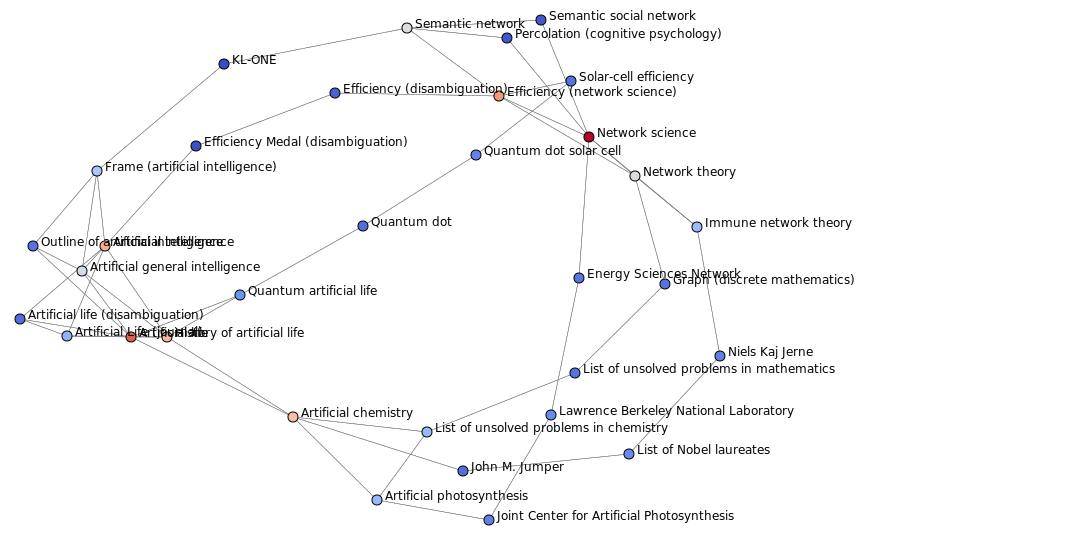

In [48]:
G_check = get_relevancy_graph(G)

draw_graph(G_check, show_names=True, node_size=5, font_size=12)

Node Cound: 128

Nodes:

A.I. Artificial Intelligence
Actor–network theory
Applications of artificial intelligence
Artificial Intelligence Act
Artificial Life (journal)
Artificial brain
Artificial chemistry
Artificial consciousness
Artificial general intelligence
Artificial intelligence
Artificial intelligence art
Artificial intelligence in healthcare
Artificial intelligence in industry
Artificial intelligence in mental health
Artificial intelligence in video games
Artificial intelligence marketing
Artificial intelligence of things
Artificial life
Artificial life (disambiguation)
Artificial photosynthesis
Artificial reproduction
Bionic Leaf
Carbon quantum dot
Discrete mathematics
Dye-sensitized solar cell
Dynamic network analysis
Dynamic program analysis
Efficiency (disambiguation)
Efficiency (network science)
Efficiency Medal (disambiguation)
Energy Sciences Network
Ethics of artificial intelligence
Explainable artificial intelligence
Frame (artificial intelligence)
Friendly artificia

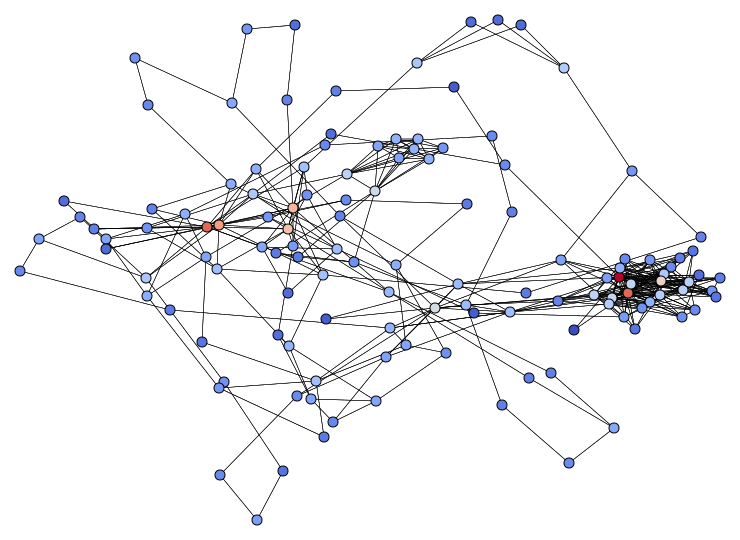

In [22]:
G_check = get_relevancy_graph(G, 4)

draw_graph(G_check, show_names=False, node_size=5, font_size=12)

Node Cound: 796

Nodes:

100% renewable energy
1911
2015 in science
2024
2024 Nobel Prizes
9/11 conspiracy theories
A Little Life
A.I. Artificial Intelligence
A.I. Artificial Intelligence (soundtrack)
ACS Synthetic Biology
AE
AI boom
AI safety
AI takeover
ANT (network)
ARPANET
Abagovomab
Academic discipline
Academic ranks in India
Actor (disambiguation)
Actor–network theory
Adaptive immune system
Advanced Life Support in Obstetrics
Advanced cardiac life support
Advanced life support
Advanced trauma life support
Airlift pump
Airline hub
Aktion T4
Alexander Wendt
Alternative abiogenesis scenarios
Am Yisrael Chai
American Automobile Association
American Chemical Society
Amorphous silicon
Analysis
Andrew Carnegie
Anterograde amnesia
Anti-idiotypic vaccine
Antibody
Antigen
Apocalyptic and post-apocalyptic fiction
Apple A18
Apple Inc.
Apple Intelligence
Apple M4
Apple Network Server
Applications of artificial intelligence
Argonne National Laboratory
Artificial Intelligence (compilation album

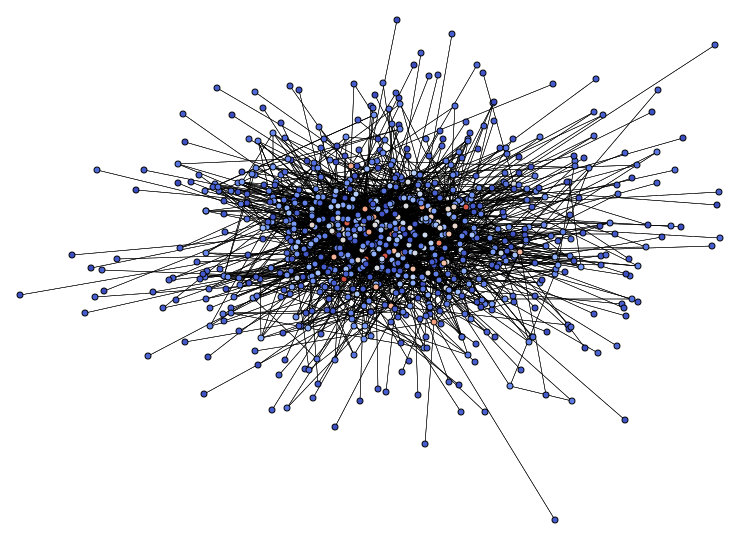

In [23]:
G_check = get_relevancy_graph(G, 5)

draw_graph(G_check, show_names=False, node_size=3, font_size=12)

# Inspect Nodes' Ego Graphs

It can be useful to explore key nodes' ego graphs to understand how the topics are interrelated. This helps builds up systems thinking, a deeper understanding of how things work.

In [24]:
def draw_ego_graph(G, ego_name, radius=1, node_size=5):

    ego = nx.ego_graph(G, ego_name, radius=radius)

    return draw_graph(ego, show_names=True, node_size=node_size, edge_width=0.2)

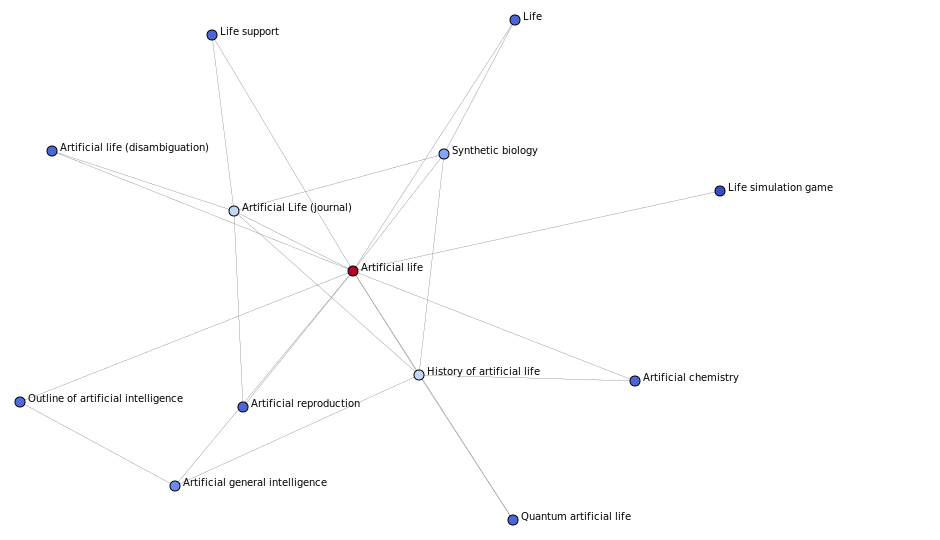

In [42]:
draw_ego_graph(G, 'Artificial life')

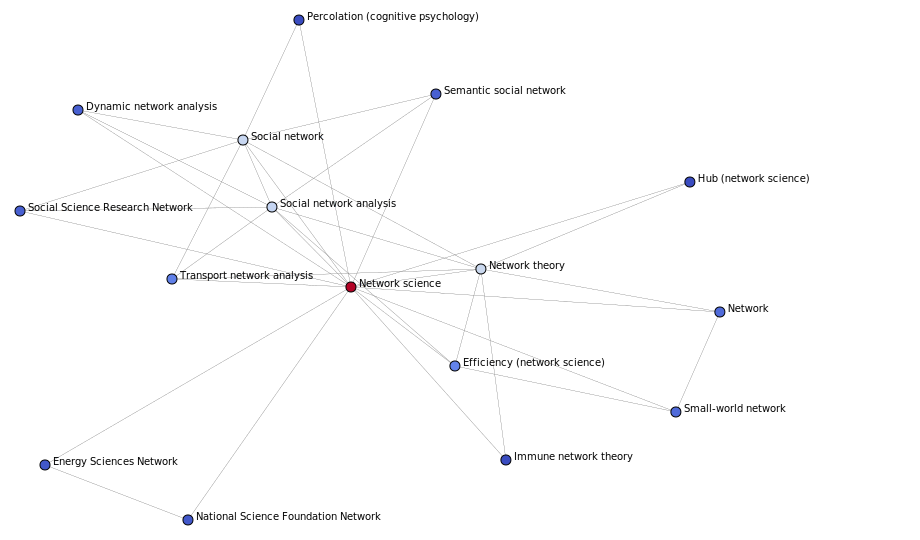

In [27]:
draw_ego_graph(G, 'Network science')

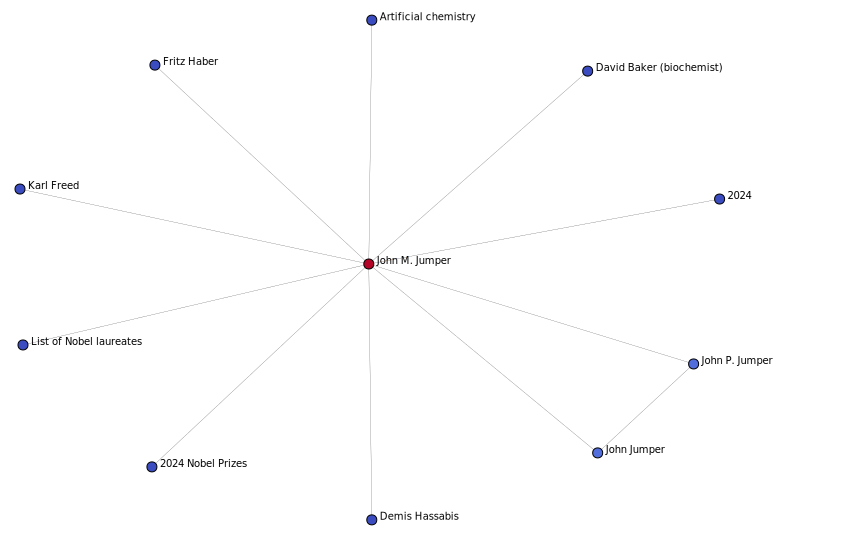

In [28]:
draw_ego_graph(G, 'John M. Jumper', radius=1)

From ChatGPT:
    
John M. Jumper is a computational scientist known for his significant contributions to artificial chemistry and the application of deep learning to structural biology. One of his most notable achievements is his involvement in the development of AlphaFold, an AI system created by DeepMind that predicts protein structures with remarkable accuracy. AlphaFold's ability to accurately predict the three-dimensional structures of proteins from their amino acid sequences is considered a monumental breakthrough in the field of biology. This tool effectively maps out the complex network of interactions within proteins, enabling scientists to understand biological processes and disease mechanisms better and to accelerate drug discovery and other biotechnological applications.

While Jumper's work primarily focuses on protein structure prediction, the methodologies and technologies he has helped develop intersect with network science by detailing the intricate networks of atomic interactions within proteins. This approach can be viewed through the lens of artificial chemistry, where computational models simulate and explore the behaviors and interactions of chemically relevant systems. Jumper’s research not only advances our understanding of biological macromolecules but also enhances our ability to model and manipulate the networks they form, bridging the gap between computational science, artificial intelligence, and biological networks. His contributions have propelled the field of computational biology forward, demonstrating the power of integrating AI and network science in understanding complex biological systems.

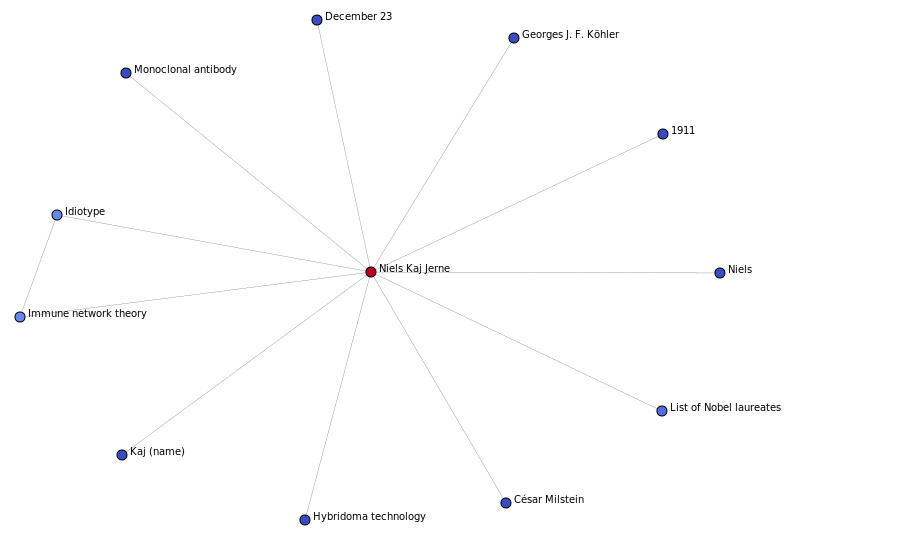

In [29]:
draw_ego_graph(G, 'Niels Kaj Jerne', radius=1)

From ChatGPT: 
    
Niels Kaj Jerne was a prominent immunologist whose groundbreaking work on the immune system earned him the Nobel Prize in Physiology or Medicine in 1984, which he shared with Georges Köhler and César Milstein. Jerne is best known for his development of the immune network theory in the 1970s, which proposed that the immune system functions as a complex network of antibodies and antigens that regulate each other. His theory suggested that antibodies can recognize not only foreign molecules but also other antibodies, creating a regulatory network that maintains the immune system’s balance and memory. This concept was pivotal because it expanded the understanding of the immune system from a simple linear array of reactions to a dynamic, interconnected system.

Jerne's immune network theory influenced many areas of immunology and theoretical biology, stimulating research into how the immune system can adapt and learn in a manner analogous to the nervous system. Although aspects of the network theory have been debated and refined, Jerne’s ideas helped to foster a more holistic view of the immune system, encouraging researchers to explore the complex interactions within it. His work has had a lasting impact on the fields of immunology, vaccine development, and autoimmune disease treatment, providing a foundational framework that has shaped modern immunological thought and practice.

From ChatGPT:
    
The intersection of network science and artificial life presents a fascinating domain where the structural and dynamic properties of complex networks inform and enhance the simulation and understanding of living systems. Network science, with its focus on the connectivity and interdependencies among various elements within a system, offers a robust framework for exploring how biological networks operate, evolve, and adapt. This is crucial in artificial life studies, where the objective is to recreate or simulate life-like behaviors and evolutionary processes in artificial environments. By leveraging network science, researchers can model the intricate interactions within ecosystems, neural networks, or genetic regulation systems, enabling a deeper understanding of the emergent properties and self-organizing principles that are hallmarks of life.

Artificial life, on the other hand, extends the application of network science by testing and validating theories about biological networks in controlled, simulated settings that mirror real-life complexity. This synergy allows for experimentation with network structures and dynamics in ways that would be impractical or impossible in natural settings, such as altering connectivity patterns or network topology to observe the effects on system behavior or evolutionary outcomes. Additionally, artificial life can incorporate evolutionary algorithms and machine learning to explore how networks evolve under different selection pressures, providing insights into the fundamental mechanisms that drive biological complexity and diversity. This collaborative approach not only enriches our understanding of life's underlying principles but also enhances our ability to engineer artificial systems and tools that mimic, interact with, or augment biological processes.

Certainly! Here are the high-level points on the overlap between network science and artificial life research:

- Network science explores connectivity and interdependencies within systems.
- Artificial life aims to simulate or recreate life-like behaviors and evolutionary processes.
- Network science provides frameworks for understanding biological networks.
- It enables modeling of interactions within ecosystems, neural networks, and genetic regulation.
- Emergent properties and self-organizing principles of life are key focus areas.
- Artificial life uses simulations to mimic and understand natural complexity.
- The synergy between the two fields allows for practical testing of biological theories.
- Changes in network structures and dynamics can be experimentally observed.
- Artificial life studies can alter network connectivity or topology experimentally.
- The effects of these changes inform on system behavior and evolution.
- Evolutionary algorithms and machine learning are integrated into artificial life.
- These technologies explore network evolution under various selection pressures.
- Insights into biological complexity and diversity are gained through these studies.
- The approach provides a deeper understanding of the mechanisms driving life.
- Artificial life research enhances the ability to engineer systems that mimic biological processes.
- It also helps in creating tools that interact with or augment biological functions.
- Both fields contribute to advancements in computational biology and bioengineering.
- They foster interdisciplinary research, blending biology with computational sciences.
- The collaboration enhances predictive models of biological and ecological outcomes.
- Ultimately, this research aids in the development of novel biotechnological applications.

These points encapsulate the rich and intricate relationship between network science and artificial life, highlighting their mutual contributions to expanding our knowledge and capabilities in understanding and creating life-like systems.

# Getting the Relevant Pages

Now that we have identified relevant pages based on average distance, we can download and read those pages. We can even use the data with NLP techniques. There are countless things you can do with text data. This isn't the end. This is the beginning. Explore what comes after this step. Maybe continue this notebook and try things out.

In [30]:
G_check = get_relevancy_graph(G)

pages = sorted(G_check.nodes)

Node Cound: 33

Nodes:

Artificial Life (journal)
Artificial chemistry
Artificial general intelligence
Artificial intelligence
Artificial life
Artificial life (disambiguation)
Artificial photosynthesis
Efficiency (disambiguation)
Efficiency (network science)
Efficiency Medal (disambiguation)
Energy Sciences Network
Frame (artificial intelligence)
Graph (discrete mathematics)
History of artificial life
Immune network theory
John M. Jumper
Joint Center for Artificial Photosynthesis
KL-ONE
Lawrence Berkeley National Laboratory
List of Nobel laureates
List of unsolved problems in chemistry
List of unsolved problems in mathematics
Network science
Network theory
Niels Kaj Jerne
Outline of artificial intelligence
Percolation (cognitive psychology)
Quantum artificial life
Quantum dot
Quantum dot solar cell
Semantic network
Semantic social network
Solar-cell efficiency


In [31]:
pages

['Artificial Life (journal)',
 'Artificial chemistry',
 'Artificial general intelligence',
 'Artificial intelligence',
 'Artificial life',
 'Artificial life (disambiguation)',
 'Artificial photosynthesis',
 'Efficiency (disambiguation)',
 'Efficiency (network science)',
 'Efficiency Medal (disambiguation)',
 'Energy Sciences Network',
 'Frame (artificial intelligence)',
 'Graph (discrete mathematics)',
 'History of artificial life',
 'Immune network theory',
 'John M. Jumper',
 'Joint Center for Artificial Photosynthesis',
 'KL-ONE',
 'Lawrence Berkeley National Laboratory',
 'List of Nobel laureates',
 'List of unsolved problems in chemistry',
 'List of unsolved problems in mathematics',
 'Network science',
 'Network theory',
 'Niels Kaj Jerne',
 'Outline of artificial intelligence',
 'Percolation (cognitive psychology)',
 'Quantum artificial life',
 'Quantum dot',
 'Quantum dot solar cell',
 'Semantic network',
 'Semantic social network',
 'Solar-cell efficiency']

In [32]:
import wikipedia

In [38]:
title = wikipedia.page(pages[4]).title
print(title)

Artificial life


In [39]:
# getting page content; text is data; can be used with NLP techniques to further analyze.

content = wikipedia.page(pages[4]).content
print(content)

Artificial life (ALife or A-Life) is a field of study wherein researchers examine systems related to natural life, its processes, and its evolution, through the use of simulations with computer models, robotics, and biochemistry. The discipline was named by Christopher Langton, an American computer scientist, in 1986. In 1987, Langton organized the first conference on the field, in Los Alamos, New Mexico. There are three main kinds of alife, named for their approaches: soft, from software; hard, from hardware; and wet, from biochemistry. Artificial life researchers study traditional biology by trying to recreate aspects of biological phenomena.


== Overview ==
Artificial life studies the fundamental processes of living systems in artificial environments in order to gain a deeper understanding of the complex information processing that define such systems.  These topics are broad, but often include evolutionary dynamics, emergent properties of collective systems, biomimicry, as well as

In [40]:
# getting relevant links

links = sorted(wikipedia.page(pages[4]).references)
links

['http://aevol.fr/',
 'http://alife.org/',
 'http://authors.library.caltech.edu/13564/1/BEDal00.pdf',
 'http://dictionary.reference.com/browse/artificial%20life',
 'http://lggwg.com/wolff/aicg99/stern.html',
 'http://libarynth.org/open_problems_in_alife',
 'http://life.ou.edu/pubs/alife2/tierra.tex',
 'http://pespmc1.vub.ac.be/MATHME.html',
 'http://www.mitpressjournals.org/loi/artl',
 'http://www.probelog.com/texts/Langton_al.pdf',
 'http://www.reed.edu/~mab/publications/papers/BedauTICS03.pdf',
 'http://zooland.alife.org/',
 'https://aleph.nkp.cz/F/?func=find-c&local_base=aut&ccl_term=ica=ph164351&CON_LNG=ENG',
 'https://api.semanticscholar.org/CorpusID:2941481',
 'https://arxiv.org/abs/0803.1087',
 'https://books.google.com/books?id=-wt1aZrGXLYC&pg=PA37',
 'https://d-nb.info/gnd/4311694-2',
 'https://doi.org/10.1007%2Fs10441-015-9257-9',
 'https://doi.org/10.1038%2Fs41586-019-1192-5',
 'https://doi.org/10.7717%2Fpeerj.948',
 'https://dx.doi.org/10.3389/frobt.2014.00008',
 'https://i